# Classification of fixed size paragraph vectors using LSTM
should be able to deal with all levels using the PARTS_LEVEL param

In [1]:
import json
import nltk
from nltk.tokenize import RegexpTokenizer
import string
import math
import os
import time
from collections import namedtuple, defaultdict
import cPickle as pickle
import pandas as pd

%matplotlib inline




import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import random

import multiprocessing
from multiprocessing.dummy import Pool as ThreadPool
import itertools

from sklearn.metrics import coverage_error
import sklearn.metrics
from sklearn.multiclass import OneVsRestClassifier
from sklearn import linear_model
from sklearn.preprocessing import MultiLabelBinarizer

from gensim.models.doc2vec import Doc2Vec, LabeledSentence

import logging
from logging import info
from functools import partial

import multiprocessing
from multiprocessing import Process, Queue

import seaborn

import keras
from keras.layers import Input, Dense, Dropout, Masking
from keras.models import Model, Sequential
from keras.layers import Input, Masking
from keras.layers.convolutional import MaxPooling1D, Convolution1D
from keras.layers.pooling import GlobalAveragePooling1D
from keras.layers.recurrent import LSTM

from sklearn.model_selection import ParameterSampler

from thesis.utils.metrics import *
from thesis.utils.file import *

Using Theano backend.
Using gpu device 0: TITAN X (Pascal) (CNMeM is disabled, cuDNN 5105)
/home/stud/shalaby/.virtualenv/thesis-env/local/lib/python2.7/site-packages/theano/sandbox/cuda/__init__.py:600: UserWarning: Your cuDNN version is more recent than the one Theano officially supports. If you see any problems, try updating Theano or downgrading cuDNN to version 5.
  warnings.warn(warn)


# Global variables used throughout the script

In [2]:
root = logging.getLogger()
for handler in root.handlers[:]:
    root.removeHandler(handler)
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO) # adds a default StreamHanlder
#root.addHandler(logging.StreamHandler())

In [3]:
SVM_SEED = 1234
DOC2VEC_SEED = 1234
WORD2VEC_SEED = 1234
NN_SEED = 1234

In [4]:
QUEUE_SIZE = 50

In [5]:
NUM_CORES = 16

In [6]:
GLOBAL_VARS = namedtuple('GLOBAL_VARS', ['MODEL_NAME', 'DOC2VEC_MODEL_NAME', 'DOC2VEC_MODEL', 
                                         'SVM_MODEL_NAME', 'NN_MODEL_NAME'])

In [7]:
VOCAB_MODEL = "vocab_model"
MODEL_PREFIX = "model"
VALIDATION_MATRIX = "validation_matrix.pkl"
VALIDATION_DICT = "validation_dict.pkl"
TEST_MATRIX = "test_matrix.pkl"
TEST_DICT = "test_dict.pkl"
METRICS = "metrics.pkl"
CLASSIFIER = "classifier.pkl"
TYPE_CLASSIFIER= "{}_classifier.pkl"

TRAINING_DATA_MATRIX = "X_level_{}.npy"
TRAINING_LABELS_MATRIX = "y_{}.npy"
VALIDATION_DATA_MATRIX = "Xv_level_{}.npy"
VALIDATION_LABELS_MATRIX = "yv_{}.npy"
TEST_DATA_MATRIX = "Xt_level_{}.npy"
TEST_LABELS_MATRIX = "yt_{}.npy"

TRAINING_DATA_MATRIX_PART = "X_level_{}-{}.npy"
TRAINING_LABELS_MATRIX_PART = "y_{}-{}.npy"

In [8]:
NN_PARAMETER_SEARCH_PREFIX = "lstm_{}_level_{}_batch_{}_nn_parameter_searches.pkl"

In [9]:
root_location = "/mnt/data2/shalaby/"
big_data_location = "/mnt/data/shalaby/"

matrices_save_location = big_data_location + "extended_pv_matrices/"
# matrices_save_location = big_data_location + "extended_pv_matrices/one_model/"
exports_location = root_location + "exported_data/"

nn_parameter_search_location = os.path.join(root_location, "nn_parameter_search_extended_abs_desc_claims_full_chunks")

doc_classifications_map_file = exports_location + "doc_classification_map.pkl"
sections_file = exports_location + "sections.pkl"
classes_file = exports_location + "classes.pkl"
subclasses_file = exports_location + "subclasses.pkl"
valid_classes_file = exports_location + "valid_classes.pkl"
valid_subclasses_file = exports_location + "valid_subclasses.pkl"
classifications_output = exports_location + "classifications.pkl"
training_docs_list_file = exports_location + "training_docs_list.pkl"
validation_docs_list_file = exports_location + "validation_docs_list.pkl"
test_docs_list_file = exports_location + "test_docs_list.pkl"

# Load general data required for classification

In [10]:
%%time
sections = pickle.load(open(sections_file))
valid_classes = pickle.load(open(valid_classes_file))
valid_subclasses = pickle.load(open(valid_subclasses_file))
training_docs_list = pickle.load(open(training_docs_list_file))
validation_docs_list = pickle.load(open(validation_docs_list_file))
test_docs_list = pickle.load(open(test_docs_list_file))

CPU times: user 2.32 s, sys: 120 ms, total: 2.44 s
Wall time: 2.44 s


In [11]:
len(training_docs_list)

1286325

In [12]:
len(validation_docs_list)

321473

In [13]:
len(test_docs_list)

401877

# Utility Functions for data loading

In [14]:
data_type_file_dict ={
    "training": TRAINING_DATA_MATRIX,
    "validation": VALIDATION_DATA_MATRIX,
    "test": TEST_DATA_MATRIX,
}
labels_type_file_dict ={
    "training": TRAINING_LABELS_MATRIX,
    "validation": VALIDATION_LABELS_MATRIX,
    "test": TEST_LABELS_MATRIX,
}

def get_data_dirs(classifications_type, level, data_type):
    data_dir = os.path.join(matrices_save_location, GLOBAL_VARS.MODEL_NAME, 
                                                data_type_file_dict[data_type].format(level))
    labels_dir = os.path.join(matrices_save_location, GLOBAL_VARS.MODEL_NAME, 
                                                labels_type_file_dict[data_type].format(classifications_type))
    return data_dir, labels_dir

def get_data(data_file, labels_file, mmap=False):
    mmap_mode = None
    if mmap == True:
        mmap_mode = "r"
    X_data = np.load(data_file, mmap_mode=mmap_mode)
    y_data = np.load(labels_file, mmap_mode=mmap_mode)
    return X_data, y_data

In [15]:
class MetricsCallback(keras.callbacks.Callback):
    """
    Callback called by keras after each epoch. Records the best validation loss and periodically checks the 
    validation metrics
    """
    def __init__(self):
        MetricsCallback.EPOCHS_BEFORE_VALIDATION = epochs_before_validation[classifications_type]
        MetricsCallback.GRAPH_MIN = metrics_graph_ranges[classifications_type]['min']
        MetricsCallback.GRAPH_MAX = metrics_graph_ranges[classifications_type]['max']
    
    def on_train_begin(self, logs={}):
        self.epoch_index = 0
        self.val_loss_reductions = 0
        self.metrics_dict = {}
        self.best_val_loss = np.iinfo(np.int32).max
        self.best_weights = None
        self.best_validation_metrics = None
        
        self.losses = []
        self.val_losses = []
        self.fig = plt.figure(figsize=(12,6), dpi=80)
        self.ax = plt.subplot(111)
    def on_epoch_end(self, epoch, logs={}):
        self.epoch_index += 1
        self.losses.append(logs['loss'])
        self.val_losses.append(logs['val_loss'])
        loss_line, = self.ax.plot(range(1,self.epoch_index+1), self.losses, 'g-', label='Training Loss')
        val_loss_line, = self.ax.plot(range(1,self.epoch_index+1), self.val_losses, 'r-', label='Validation Loss')
        self.ax.legend(handles=[loss_line, val_loss_line])
        self.ax.set_ylim((MetricsCallback.GRAPH_MIN, MetricsCallback.GRAPH_MAX))
        self.fig.canvas.draw()
        if logs['val_loss'] < self.best_val_loss:
            self.val_loss_reductions += 1
            self.best_val_loss = logs['val_loss']
            self.best_weights = self.model.get_weights()
            print '\r    \r' # to remove the previous line of verbose output of model fit
            #time.sleep(0.1)
            info('Found lower val loss for epoch {} => {}'.format(self.epoch_index, round(logs['val_loss'], 5)))
            if self.val_loss_reductions % MetricsCallback.EPOCHS_BEFORE_VALIDATION == 0:
                
                info('Validation Loss Reduced {} times'.format(self.val_loss_reductions))
                info('Evaluating on Validation Data')
                Xv_file, yv_file = get_data_dirs(classifications_type, PARTS_LEVEL, 'validation')
                Xv, yv = get_data(Xv_file, yv_file, mmap=True)
                yvp = self.model.predict_generator(generator=batch_generator(Xv_file, yv_file, NN_BATCH_SIZE, is_mlp=False, validate=True),\
                                       max_q_size=QUEUE_SIZE,\
                                       val_samples=len(validation_docs_list))
                yvp_binary = get_binary_0_5(yvp)
                info('Generating Validation Metrics')
                validation_metrics = get_metrics(yv, yvp, yvp_binary)
                print "****** Validation Metrics: Cov Err: {:.3f} | Top 3: {:.3f} | Top 5: {:.3f} | F1 Micro: {:.3f} | F1 Macro: {:.3f}".format(
                    validation_metrics['coverage_error'], validation_metrics['top_3'], validation_metrics['top_5'], 
                    validation_metrics['f1_micro'], validation_metrics['f1_macro'])
                self.metrics_dict[self.epoch_index] = validation_metrics
#                 self.best_validation_metrics = validation_metrics

In [16]:
def create_keras_rnn_model(input_size, output_size, lstm_output_size, w_dropout_do, u_dropout_do, 
                           stack_layers=1, conv_size=None, conv_filter_length=3, max_pooling_length=None):
    
    model= Sequential()
#     model.add(Masking(mask_value=0., input_shape=(MAX_SIZE, input_size)))
    if conv_size:
        model.add(Convolution1D(nb_filter=conv_size, input_shape=(MAX_SIZE, input_size), filter_length=conv_filter_length, 
                                border_mode='same', activation='relu'))
        if max_pooling_length is not None:
            model.add(MaxPooling1D(pool_length=max_pooling_length))
    for i in range(stack_layers):
        model.add(LSTM(lstm_output_size, input_dim=input_size, dropout_W=w_dropout_do, dropout_U=u_dropout_do,
                       return_sequences=False if i+1 == stack_layers else True,
                  name='lstm_{}_w-drop_{}_u-drop_{}_layer_{}'.format(lstm_output_size, str(u_dropout_do), str(w_dropout_do), str(i+1))))
    model.add(Dense(output_size, activation='sigmoid', name='sigmoid_output'))
    model.compile(optimizer=NN_OPTIMIZER, loss='binary_crossentropy')
    return model

In [17]:
class ArrayReader(Process):
    def __init__(self, input_file, label_file, out_queue, batch_size, is_mlp=False, validate=False):
        super(ArrayReader, self).__init__()
        self.is_mlp = is_mlp
        self.validate = validate
        self.q = out_queue
        self.batch_size = batch_size
        self.input_file = input_file
        self.label_file = label_file

    def run(self):
        x_file = np.load(self.input_file, mmap_mode='r')
        y_file = np.load(self.label_file, mmap_mode='r')
        start_item = 0
        num_iter = 0
#         shuffled_indices = np.arange(y_file.shape[0])
#         np.random.shuffle(shuffled_indices)
        while True:
            if start_item > y_file.shape[0]:
                info('in new epoch for {}'.format(os.path.basename(self.input_file)))
#                 np.random.seed(42 + num_iter)
#                 np.random.shuffle(shuffled_indices)
                start_item = 0
#             start_time = time.time()
            x_file[0:200000]
#             y_batch = np.copy(y_file[start_item: start_item + self.batch_size])
#             x_batch = np.copy(x_file[start_item: start_item + self.batch_size])
            y_batch = y_file[start_item: start_item + self.batch_size]
            x_batch = x_file[start_item: start_item + self.batch_size]
#             batch_indices = shuffled_indices[start_item: start_item + self.batch_size]
#             x_batch = x_file[batch_indices]
#             y_batch = y_file[batch_indices]
#             print 'Duration: {}'.format(str(time.time() - start_time))
            # because we use MLP
            if self.is_mlp:
                x_batch = np.reshape(x_batch, (x_batch.shape[0], x_batch.shape[1] * x_batch.shape[2]))
            start_item += self.batch_size
            num_iter += 1
            try:
                #print 'adding new batch'
                self.q.put((x_batch, y_batch), block=True)
            except:
                return

            
def batch_generator(input_file, label_file, batch_size, is_mlp=False, validate=False):
    q = Queue(maxsize=QUEUE_SIZE)
    p = ArrayReader(input_file, label_file, q, batch_size, is_mlp, validate)
    p.start()
    while True:
        item = q.get()
        if not item:
            p.terminate()
            raise StopIteration()
        else:
            yield item

# Global Param Loop

In [18]:
# minimum change in val_loss from previous epoch to register as a decrease
early_stopper_deltas = {
    'sections': 0.00001,
    'classes': 0.00001,
    'subclasses': 0.00001
}
# how many epochs to wait when there is no decrease in val_loss before early stopping
early_stopper_patience = {
    'sections': 15,
    'classes': 15,
    'subclasses': 15
}
# number of epochs after which we do periodic evaluation of validation metrics
epochs_before_validation = {
    'sections': 10,
    'classes': 20,
    'subclasses': 20
}

# ranges for learning graph shown
metrics_graph_ranges = {
    'sections': {'min':0, 'max': 0.3},
    'classes': {'min':0, 'max': 0.05},
    'subclasses': {'min':0, 'max': 0.05}
}

In [19]:
LEVEL_DOC = 1
LEVEL_DIVISIONS = 2
LEVEL_CHUNKS = 3

In [20]:
DOC2VEC_SIZE = 200
DOC2VEC_WINDOW = 2
DOC2VEC_MAX_VOCAB_SIZE = None
DOC2VEC_SAMPLE = 1e-3
DOC2VEC_TYPE = 1
DOC2VEC_HIERARCHICAL_SAMPLE = 0
DOC2VEC_NEGATIVE_SAMPLE_SIZE = 10
DOC2VEC_CONCAT = 0
DOC2VEC_MEAN = 1
DOC2VEC_TRAIN_WORDS = 0
DOC2VEC_EPOCHS = 1 # we do our training manually one epoch at a time
DOC2VEC_MAX_EPOCHS = 8
REPORT_DELAY = 20 # report the progress every x seconds
REPORT_VOCAB_PROGRESS = 100000 # report vocab progress every x documents

DOC2VEC_EPOCH = 8

In [22]:
GLOBAL_PARMS_TO_RUN = [
    {
        'doc2vec_epoch': DOC2VEC_EPOCH,
        'classifications': sections,
        'classifications_type': 'sections',
        'parts_level': LEVEL_CHUNKS,
        'nn_batch_size': 1024,
        'lstm_output_size': 1000,
        'lstm_w_dropout': 0.5,
        'lstm_u_dropout': 0.5,
        'lstm_stack_layers': 2,
        'lstm_conv_size': None,
        'lstm_conv_filter_length': None,
        'lstm_max_pooling_length': None
    }
]


==================================== NEW PARAM SET ============================================
{'lstm_conv_filter_length': None, 'lstm_stack_layers': 2, 'nn_batch_size': 1024, 'classifications_type': 'sections', 'lstm_w_dropout': 0.5, 'lstm_max_pooling_length': None, 'lstm_u_dropout': 0.5, 'parts_level': 3, 'lstm_output_size': 1000, 'doc2vec_epoch': 8, 'lstm_conv_size': None}
doc2vec_size_200_w_2_type_dm_concat_0_mean_1_trainwords_0_hs_0_neg_10_vocabsize_None/epoch_8


2017-04-19 13:25:36,826 : INFO : No Previous results exist in /mnt/data2/shalaby/nn_parameter_search_extended_abs_desc_claims_full_chunks/doc2vec_size_200_w_2_type_dm_concat_0_mean_1_trainwords_0_hs_0_neg_10_vocabsize_None/epoch_8/lstm_sections_level_3_batch_1024_nn_parameter_searches.pkl
2017-04-19 13:25:36,827 : INFO : ***************************************************************************************
2017-04-19 13:25:36,829 : INFO : lstm_optimizer_rmsprop_size_1000_w-drop_0.5_u-drop_0.5_stack_2_conv_None


____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
lstm_1000_w-drop_0.5_u-drop_0.5_ (None, None, 1000)    4804000     lstm_input_1[0][0]               
____________________________________________________________________________________________________
lstm_1000_w-drop_0.5_u-drop_0.5_ (None, 1000)          8004000     lstm_1000_w-drop_0.5_u-drop_0.5_l
____________________________________________________________________________________________________
sigmoid_output (Dense)           (None, 8)             8008        lstm_1000_w-drop_0.5_u-drop_0.5_l
Total params: 12,816,008
Trainable params: 12,816,008
Non-trainable params: 0
____________________________________________________________________________________________________


<IPython.core.display.Javascript object>


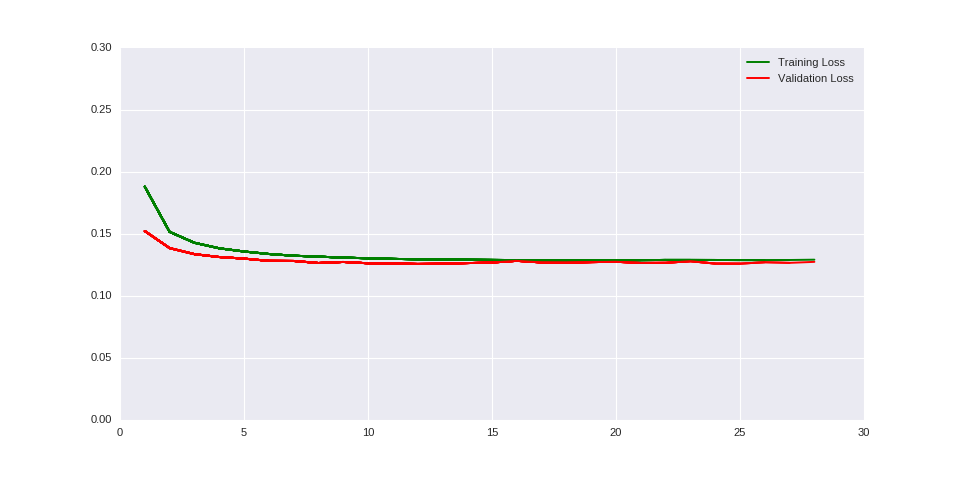

Epoch 1/200
1183744/1286325 [==========================>...] - ETA: 124s - loss: 0.1899

2017-04-19 13:50:12,685 : INFO : in new epoch for X_level_3.npy


1286144/1286325 [============================>.] - ETA: 0s - loss: 0.1881

2017-04-19 13:53:56,824 : INFO : in new epoch for Xv_level_3.npy
2017-04-19 13:54:43,173 : INFO : Found lower val loss for epoch 1 => 0.15238


    
1286325/1286325 [==============================] - 1709s - loss: 0.1881 - val_loss: 0.1524
Epoch 2/200
1183744/1286325 [==========================>...] - ETA: 129s - loss: 0.1517

2017-04-19 14:19:33,658 : INFO : in new epoch for X_level_3.npy


1286144/1286325 [============================>.] - ETA: 0s - loss: 0.1517

2017-04-19 14:22:56,651 : INFO : in new epoch for Xv_level_3.npy
2017-04-19 14:24:02,855 : INFO : Found lower val loss for epoch 2 => 0.13864


    
1286325/1286325 [==============================] - 1759s - loss: 0.1517 - val_loss: 0.1386
Epoch 3/200
1183744/1286325 [==========================>...] - ETA: 128s - loss: 0.1427

2017-04-19 14:48:47,804 : INFO : in new epoch for X_level_3.npy


1286144/1286325 [============================>.] - ETA: 0s - loss: 0.1429

2017-04-19 14:51:48,280 : INFO : in new epoch for Xv_level_3.npy
2017-04-19 14:53:15,097 : INFO : Found lower val loss for epoch 3 => 0.13374


    
1286325/1286325 [==============================] - 1752s - loss: 0.1429 - val_loss: 0.1337
Epoch 4/200
1183744/1286325 [==========================>...] - ETA: 125s - loss: 0.1382

2017-04-19 15:17:27,298 : INFO : in new epoch for X_level_3.npy


1286144/1286325 [============================>.] - ETA: 0s - loss: 0.1385

2017-04-19 15:20:02,192 : INFO : in new epoch for Xv_level_3.npy
2017-04-19 15:21:55,407 : INFO : Found lower val loss for epoch 4 => 0.13143


    
1286325/1286325 [==============================] - 1720s - loss: 0.1385 - val_loss: 0.1314
Epoch 5/200
1183744/1286325 [==========================>...] - ETA: 124s - loss: 0.1356

2017-04-19 15:45:53,671 : INFO : in new epoch for X_level_3.npy


1286144/1286325 [============================>.] - ETA: 0s - loss: 0.1359

2017-04-19 15:48:05,060 : INFO : in new epoch for Xv_level_3.npy
2017-04-19 15:50:17,577 : INFO : Found lower val loss for epoch 5 => 0.13017


    
1286325/1286325 [==============================] - 1702s - loss: 0.1359 - val_loss: 0.1302
Epoch 6/200
1183744/1286325 [==========================>...] - ETA: 124s - loss: 0.1336

2017-04-19 16:14:14,281 : INFO : in new epoch for X_level_3.npy


1286144/1286325 [============================>.] - ETA: 0s - loss: 0.1339

2017-04-19 16:16:19,534 : INFO : in new epoch for Xv_level_3.npy
2017-04-19 16:18:23,154 : INFO : in new epoch for Xv_level_3.npy
2017-04-19 16:18:39,927 : INFO : Found lower val loss for epoch 6 => 0.12833


    
1286325/1286325 [==============================] - 1702s - loss: 0.1339 - val_loss: 0.1283
Epoch 7/200
1183744/1286325 [==========================>...] - ETA: 124s - loss: 0.1322

2017-04-19 16:42:33,782 : INFO : in new epoch for X_level_3.npy


1286144/1286325 [============================>.] - ETA: 0s - loss: 0.1325

2017-04-19 16:46:24,171 : INFO : in new epoch for Xv_level_3.npy
2017-04-19 16:47:04,746 : INFO : Found lower val loss for epoch 7 => 0.12826


    
1286325/1286325 [==============================] - 1704s - loss: 0.1325 - val_loss: 0.1283
Epoch 8/200
1183744/1286325 [==========================>...] - ETA: 124s - loss: 0.1315

2017-04-19 17:11:01,599 : INFO : in new epoch for X_level_3.npy


1286144/1286325 [============================>.] - ETA: 0s - loss: 0.1318

2017-04-19 17:14:26,355 : INFO : in new epoch for Xv_level_3.npy
2017-04-19 17:15:27,238 : INFO : Found lower val loss for epoch 8 => 0.12662


    
1286325/1286325 [==============================] - 1702s - loss: 0.1317 - val_loss: 0.1266
Epoch 9/200
1183744/1286325 [==========================>...] - ETA: 124s - loss: 0.1307

2017-04-19 17:39:26,163 : INFO : in new epoch for X_level_3.npy


1286144/1286325 [============================>.] - ETA: 0s - loss: 0.1310

2017-04-19 17:42:27,484 : INFO : in new epoch for Xv_level_3.npy


1286325/1286325 [==============================] - 1702s - loss: 0.1310 - val_loss: 0.1275
Epoch 10/200
1183744/1286325 [==========================>...] - ETA: 123s - loss: 0.1301

2017-04-19 18:07:34,550 : INFO : in new epoch for X_level_3.npy


1286144/1286325 [============================>.] - ETA: 0s - loss: 0.1304

2017-04-19 18:10:12,444 : INFO : in new epoch for Xv_level_3.npy
2017-04-19 18:11:53,296 : INFO : Found lower val loss for epoch 10 => 0.1264


    
1286325/1286325 [==============================] - 1683s - loss: 0.1304 - val_loss: 0.1264
Epoch 11/200
1183744/1286325 [==========================>...] - ETA: 123s - loss: 0.1296

2017-04-19 18:35:38,735 : INFO : in new epoch for X_level_3.npy


1286144/1286325 [============================>.] - ETA: 0s - loss: 0.1299

2017-04-19 18:37:54,794 : INFO : in new epoch for Xv_level_3.npy
2017-04-19 18:39:59,274 : INFO : Found lower val loss for epoch 11 => 0.12623
2017-04-19 18:39:59,276 : INFO : Validation Loss Reduced 10 times
2017-04-19 18:39:59,277 : INFO : Evaluating on Validation Data


2017-04-19 18:41:45,701 : INFO : in new epoch for Xv_level_3.npy
2017-04-19 18:42:32,962 : INFO : Generating Validation Metrics


****** Validation Metrics: Cov Err: 1.372 | Top 3: 0.980 | Top 5: 0.997 | F1 Micro: 0.819 | F1 Macro: 0.774
1286325/1286325 [==============================] - 1851s - loss: 0.1299 - val_loss: 0.1262
Epoch 12/200
1183744/1286325 [==========================>...] - ETA: 129s - loss: 0.1293

2017-04-19 19:07:37,940 : INFO : in new epoch for X_level_3.npy


1286144/1286325 [============================>.] - ETA: 0s - loss: 0.1296

2017-04-19 19:09:46,665 : INFO : in new epoch for Xv_level_3.npy
2017-04-19 19:11:59,858 : INFO : in new epoch for Xv_level_3.npy
2017-04-19 19:12:10,862 : INFO : Found lower val loss for epoch 12 => 0.12585


    
1286325/1286325 [==============================] - 1765s - loss: 0.1296 - val_loss: 0.1258
Epoch 13/200
1183744/1286325 [==========================>...] - ETA: 126s - loss: 0.1290

2017-04-19 19:36:27,095 : INFO : in new epoch for X_level_3.npy


1286144/1286325 [============================>.] - ETA: 0s - loss: 0.1293

2017-04-19 19:40:23,543 : INFO : in new epoch for Xv_level_3.npy


1286325/1286325 [==============================] - 1727s - loss: 0.1293 - val_loss: 0.1260
Epoch 14/200
1183744/1286325 [==========================>...] - ETA: 125s - loss: 0.1289

2017-04-19 20:05:05,339 : INFO : in new epoch for X_level_3.npy


1286144/1286325 [============================>.] - ETA: 0s - loss: 0.1292

2017-04-19 20:08:34,626 : INFO : in new epoch for Xv_level_3.npy


1286325/1286325 [==============================] - 1711s - loss: 0.1292 - val_loss: 0.1265
Epoch 15/200
1183744/1286325 [==========================>...] - ETA: 125s - loss: 0.1288

2017-04-19 20:33:33,088 : INFO : in new epoch for X_level_3.npy


1286144/1286325 [============================>.] - ETA: 0s - loss: 0.1291

2017-04-19 20:36:43,798 : INFO : in new epoch for Xv_level_3.npy


1286325/1286325 [==============================] - 1714s - loss: 0.1291 - val_loss: 0.1270
Epoch 16/200
1183744/1286325 [==========================>...] - ETA: 125s - loss: 0.1287

2017-04-19 21:02:07,094 : INFO : in new epoch for X_level_3.npy


1286144/1286325 [============================>.] - ETA: 0s - loss: 0.1290

2017-04-19 21:04:51,187 : INFO : in new epoch for Xv_level_3.npy


1286325/1286325 [==============================] - 1703s - loss: 0.1290 - val_loss: 0.1283
Epoch 17/200
1183744/1286325 [==========================>...] - ETA: 125s - loss: 0.1285

2017-04-19 21:30:31,991 : INFO : in new epoch for X_level_3.npy


1286144/1286325 [============================>.] - ETA: 0s - loss: 0.1288

2017-04-19 21:32:57,876 : INFO : in new epoch for Xv_level_3.npy


1286325/1286325 [==============================] - 1717s - loss: 0.1288 - val_loss: 0.1270
Epoch 18/200
1183744/1286325 [==========================>...] - ETA: 124s - loss: 0.1286

2017-04-19 21:59:06,677 : INFO : in new epoch for X_level_3.npy


1286144/1286325 [============================>.] - ETA: 0s - loss: 0.1289

2017-04-19 22:01:13,821 : INFO : in new epoch for Xv_level_3.npy
2017-04-19 22:03:25,722 : INFO : in new epoch for Xv_level_3.npy


1286325/1286325 [==============================] - 1705s - loss: 0.1289 - val_loss: 0.1268
Epoch 19/200
1183744/1286325 [==========================>...] - ETA: 124s - loss: 0.1287

2017-04-19 22:27:31,277 : INFO : in new epoch for X_level_3.npy


1286144/1286325 [============================>.] - ETA: 0s - loss: 0.1289

2017-04-19 22:31:32,985 : INFO : in new epoch for Xv_level_3.npy


1286325/1286325 [==============================] - 1711s - loss: 0.1289 - val_loss: 0.1273
Epoch 20/200
1183744/1286325 [==========================>...] - ETA: 125s - loss: 0.1286

2017-04-19 22:56:05,771 : INFO : in new epoch for X_level_3.npy


1286144/1286325 [============================>.] - ETA: 0s - loss: 0.1289

2017-04-19 22:59:39,893 : INFO : in new epoch for Xv_level_3.npy


1286325/1286325 [==============================] - 1706s - loss: 0.1289 - val_loss: 0.1276
Epoch 21/200
1183744/1286325 [==========================>...] - ETA: 125s - loss: 0.1286

2017-04-19 23:24:30,886 : INFO : in new epoch for X_level_3.npy


1286144/1286325 [============================>.] - ETA: 0s - loss: 0.1289

2017-04-19 23:27:48,165 : INFO : in new epoch for Xv_level_3.npy


1286325/1286325 [==============================] - 1713s - loss: 0.1289 - val_loss: 0.1266
Epoch 22/200
1183744/1286325 [==========================>...] - ETA: 124s - loss: 0.1288

2017-04-19 23:53:02,594 : INFO : in new epoch for X_level_3.npy


1286144/1286325 [============================>.] - ETA: 0s - loss: 0.1291

2017-04-19 23:55:53,285 : INFO : in new epoch for Xv_level_3.npy


1286325/1286325 [==============================] - 1703s - loss: 0.1291 - val_loss: 0.1267
Epoch 23/200
1183744/1286325 [==========================>...] - ETA: 125s - loss: 0.1288

2017-04-20 00:21:30,480 : INFO : in new epoch for X_level_3.npy


1286144/1286325 [============================>.] - ETA: 0s - loss: 0.1291

2017-04-20 00:24:02,495 : INFO : in new epoch for Xv_level_3.npy


1286325/1286325 [==============================] - 1716s - loss: 0.1291 - val_loss: 0.1281
Epoch 24/200
1183744/1286325 [==========================>...] - ETA: 125s - loss: 0.1288

2017-04-20 00:50:04,973 : INFO : in new epoch for X_level_3.npy


1286144/1286325 [============================>.] - ETA: 0s - loss: 0.1291

2017-04-20 00:52:12,251 : INFO : in new epoch for Xv_level_3.npy


1286325/1286325 [==============================] - 1706s - loss: 0.1291 - val_loss: 0.1261
Epoch 25/200
1183744/1286325 [==========================>...] - ETA: 125s - loss: 0.1287

2017-04-20 01:18:38,460 : INFO : in new epoch for X_level_3.npy


1286144/1286325 [============================>.] - ETA: 0s - loss: 0.1290

2017-04-20 01:20:43,330 : INFO : in new epoch for Xv_level_3.npy
2017-04-20 01:22:45,261 : INFO : in new epoch for Xv_level_3.npy


1286325/1286325 [==============================] - 1717s - loss: 0.1290 - val_loss: 0.1261
Epoch 26/200
1183744/1286325 [==========================>...] - ETA: 125s - loss: 0.1286

2017-04-20 01:47:11,052 : INFO : in new epoch for X_level_3.npy


1286144/1286325 [============================>.] - ETA: 0s - loss: 0.1289

2017-04-20 01:50:50,772 : INFO : in new epoch for Xv_level_3.npy


1286325/1286325 [==============================] - 1706s - loss: 0.1289 - val_loss: 0.1272
Epoch 27/200
1183744/1286325 [==========================>...] - ETA: 123s - loss: 0.1287

2017-04-20 02:15:20,704 : INFO : in new epoch for X_level_3.npy


1286144/1286325 [============================>.] - ETA: 0s - loss: 0.1290

2017-04-20 02:18:34,036 : INFO : in new epoch for Xv_level_3.npy


1286325/1286325 [==============================] - 1686s - loss: 0.1290 - val_loss: 0.1267
Epoch 28/200
1183744/1286325 [==========================>...] - ETA: 120s - loss: 0.1290

2017-04-20 02:42:51,494 : INFO : in new epoch for X_level_3.npy


1286144/1286325 [============================>.] - ETA: 0s - loss: 0.1293

2017-04-20 02:45:43,005 : INFO : in new epoch for Xv_level_3.npy


1286325/1286325 [==============================] - 1646s - loss: 0.1293 - val_loss: 0.1275
Epoch 00027: early stopping
CPU times: user 5h 9min 59s, sys: 7h 49min 19s, total: 12h 59min 19s
Wall time: 13h 21min 25s


2017-04-20 02:47:05,527 : INFO : Evaluating on Validation Data using saved best weights
2017-04-20 02:48:37,664 : INFO : in new epoch for Xv_level_3.npy
2017-04-20 02:49:21,172 : INFO : Generating Validation Metrics


****** Validation Metrics: Cov Err: 1.371 | Top 3: 0.980 | Top 5: 0.997 | F1 Micro: 0.819 | F1 Macro: 0.774


In [23]:
%matplotlib notebook

for GLOBAL_PARAMS in GLOBAL_PARMS_TO_RUN:
    
    print '==================================== NEW PARAM SET ============================================'
    print {k:v for k,v in GLOBAL_PARAMS.items() if k != 'classifications'}
    
    classifications = GLOBAL_PARAMS['classifications']
    classifications_type = GLOBAL_PARAMS['classifications_type']
    classifier_file = TYPE_CLASSIFIER.format(classifications_type)
    
    PARTS_LEVEL = GLOBAL_PARAMS['parts_level']
    
    
    placeholder_model_name = 'doc2vec_size_{}_w_{}_type_{}_concat_{}_mean_{}_trainwords_{}_hs_{}_neg_{}_vocabsize_{}'.format(DOC2VEC_SIZE, 
                                                                DOC2VEC_WINDOW, 
                                                                'dm' if DOC2VEC_TYPE == 1 else 'pv-dbow',
                                                                DOC2VEC_CONCAT, DOC2VEC_MEAN,
                                                                DOC2VEC_TRAIN_WORDS,
                                                                DOC2VEC_HIERARCHICAL_SAMPLE,DOC2VEC_NEGATIVE_SAMPLE_SIZE,
                                                                str(DOC2VEC_MAX_VOCAB_SIZE))
    GLOBAL_VARS.DOC2VEC_MODEL_NAME = placeholder_model_name
    placeholder_model_name = os.path.join(placeholder_model_name, "epoch_{}")

    epoch = GLOBAL_PARAMS['doc2vec_epoch']

    GLOBAL_VARS.MODEL_NAME = placeholder_model_name.format(epoch)
    print GLOBAL_VARS.MODEL_NAME
    
    time.sleep(0.2)
    
    
    X_file, y_file = get_data_dirs(classifications_type, PARTS_LEVEL, 'training')
    Xv_file, yv_file = get_data_dirs(classifications_type, PARTS_LEVEL, 'validation')
    X, y = get_data(X_file, y_file, mmap=True)
    
    
#     info("Loading Validation Documents")
#     Xv, yv = get_validation_data(classifications_type, PARTS_LEVEL)
#     print Xv.shape
#     print yv.shape
    
    NN_INPUT_NEURONS = DOC2VEC_SIZE
    NN_OUTPUT_NEURONS = len(classifications)
    EARLY_STOPPER_MIN_DELTA = early_stopper_deltas[classifications_type]
    EARLY_STOPPER_PATIENCE = early_stopper_patience[classifications_type]

    NN_MAX_EPOCHS = 200
    NN_PARAM_SAMPLE_SEED = 1234

    NN_BATCH_SIZE = GLOBAL_PARAMS['nn_batch_size']

    MODEL_VERBOSITY = 2

    NN_OPTIMIZER = 'rmsprop'
    # NN_OPTIMIZER = 'adam'

    to_skip = []

    load_existing_results = True
    save_results = True


    np.random.seed(NN_SEED)
    
    
    
    ################################################################################
    ############### Actual Training


    # load previous finshed results so we dont redo them
    param_results_dict = {}
    
    param_results_path = os.path.join(os.path.join(nn_parameter_search_location, GLOBAL_VARS.MODEL_NAME, 
                                                   NN_PARAMETER_SEARCH_PREFIX.format(classifications_type, PARTS_LEVEL, NN_BATCH_SIZE)))
        
    if load_existing_results:
        if os.path.exists(param_results_path):
            info('Loading Previous results from {}'.format(param_results_path))
            param_results_dict = pickle.load(open(param_results_path))
        else:
            info('No Previous results exist in {}'.format(param_results_path))

    ensure_disk_location_exists(os.path.join(nn_parameter_search_location, GLOBAL_VARS.MODEL_NAME))

    start_time = time.time()
    lstm_output_size = GLOBAL_PARAMS['lstm_output_size']
    w_dropout_do = GLOBAL_PARAMS['lstm_w_dropout']
    u_dropout_do = GLOBAL_PARAMS['lstm_u_dropout']
    stack_layers = GLOBAL_PARAMS['lstm_stack_layers']
    conv_size = GLOBAL_PARAMS['lstm_conv_size']
    conv_filter_length = GLOBAL_PARAMS['lstm_conv_filter_length']
    conv_max_pooling_length = GLOBAL_PARAMS['lstm_max_pooling_length']

    GLOBAL_VARS.NN_MODEL_NAME = 'lstm_optimizer_{}_size_{}_w-drop_{}_u-drop_{}_stack_{}_conv_{}'.format(NN_OPTIMIZER,
        lstm_output_size,  w_dropout_do, u_dropout_do, stack_layers, str(conv_size)
    )
    if conv_size:
        GLOBAL_VARS.NN_MODEL_NAME += '_conv-filter-length_{}_max-pooling-size_{}'.format(conv_filter_length, 
                                                                                         conv_max_pooling_length)

    if GLOBAL_VARS.NN_MODEL_NAME in param_results_dict.keys() or GLOBAL_VARS.NN_MODEL_NAME in to_skip:
        print "skipping: {}".format(GLOBAL_VARS.NN_MODEL_NAME)
        continue

    info('***************************************************************************************')
    info(GLOBAL_VARS.NN_MODEL_NAME)

    # creating the actual keras model
    model = create_keras_rnn_model(NN_INPUT_NEURONS, NN_OUTPUT_NEURONS, 
                                  lstm_output_size, w_dropout_do, u_dropout_do, stack_layers, conv_size, 
                                   conv_filter_length, conv_max_pooling_length)
    model.summary()

    # callbacks for early stopping and for generating validation metrics
    early_stopper = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=EARLY_STOPPER_MIN_DELTA, \
                                                  patience=EARLY_STOPPER_PATIENCE, verbose=1, mode='auto')
    metrics_callback = MetricsCallback()


    # Model Fitting
    %time history = model.fit_generator(generator=batch_generator(X_file, y_file, NN_BATCH_SIZE, is_mlp=False, validate=False),\
                                        validation_data=batch_generator(Xv_file, yv_file, NN_BATCH_SIZE, is_mlp=False, validate=True),\
                                        samples_per_epoch=len(training_docs_list), \
                                        nb_val_samples=len(validation_docs_list),\
                                        nb_epoch=NN_MAX_EPOCHS,\
                                        callbacks=[early_stopper, metrics_callback],\
                                        max_q_size=QUEUE_SIZE)
                                        #validation_data=(Xv,yv), 
                                        
    
    time.sleep(0.2)
    info('Evaluating on Validation Data using saved best weights')
    model.set_weights(metrics_callback.best_weights)
    yvp = model.predict_generator(generator=batch_generator(Xv_file, yv_file, NN_BATCH_SIZE, is_mlp=False, validate=True),\
                                       max_q_size=QUEUE_SIZE,\
                                       val_samples=len(validation_docs_list))
    yvp_binary = get_binary_0_5(yvp) # use 0.5 as threshold for setting labels to 0 or 1
    Xv, yv = get_data(Xv_file, yv_file, mmap=True)
    #print yvp
    info('Generating Validation Metrics')
    validation_metrics = get_metrics(yv, yvp, yvp_binary)
    print "****** Validation Metrics: Cov Err: {:.3f} | Top 3: {:.3f} | Top 5: {:.3f} | F1 Micro: {:.3f} | F1 Macro: {:.3f}".format(
        validation_metrics['coverage_error'], validation_metrics['top_3'], validation_metrics['top_5'], 
        validation_metrics['f1_micro'], validation_metrics['f1_macro'])
    best_validation_metrics = validation_metrics
    
    time.sleep(0.2)
    param_results_dict[GLOBAL_VARS.NN_MODEL_NAME] = dict()
    param_results_dict[GLOBAL_VARS.NN_MODEL_NAME]['best_validation_metrics'] = best_validation_metrics
    param_results_dict[GLOBAL_VARS.NN_MODEL_NAME]['epochs'] = len(history.history['val_loss'])
    param_results_dict[GLOBAL_VARS.NN_MODEL_NAME]['best_weights'] = metrics_callback.best_weights
    param_results_dict[GLOBAL_VARS.NN_MODEL_NAME]['best_val_loss'] = metrics_callback.best_val_loss
    param_results_dict[GLOBAL_VARS.NN_MODEL_NAME]['training_loss'] = metrics_callback.losses
    param_results_dict[GLOBAL_VARS.NN_MODEL_NAME]['validation_loss'] = metrics_callback.val_losses

    duration = time.time() - start_time
    param_results_dict[GLOBAL_VARS.NN_MODEL_NAME]['duration'] =  duration

#     del history, metrics_callback, model

    for p in multiprocessing.active_children():
        # closing the array readers
        p.terminate()

    if save_results:
        if load_existing_results:
            if os.path.exists(param_results_path):
                info('Loading Previous results from {}'.format(param_results_path))
                loaded_param_results_dict = pickle.load(open(param_results_path))
                param_results_dict.update(loaded_param_results_dict)

        pickle.dump(param_results_dict, open(param_results_path, 'w'))
        

In [34]:
print "****** Validation Metrics: Cov Err: {:.3f} | Top 3: {:.3f} | Top 5: {:.3f} | F1 Micro: {:.3f} | F1 Macro: {:.3f}".format(
        validation_metrics['coverage_error'], validation_metrics['top_3'], validation_metrics['top_5'], 
        validation_metrics['f1_micro'], validation_metrics['f1_macro'])

****** Validation Metrics: Cov Err: 2.389 | Top 3: 0.890 | Top 5: 0.940 | F1 Micro: 0.720 | F1 Macro: 0.252


In [32]:
param_results_dict['lstm_optimizer_rmsprop_size_1000_w-drop_0.5_u-drop_0.5_stack_1_conv_None']['best_val_loss']

0.0075913524570534914

In [30]:
param_results_dict['lstm_optimizer_rmsprop_size_1000_w-drop_0.5_u-drop_0.5_stack_1_conv_None']['validation_loss']

[0.01050170663879005,
 0.0090657171222329001,
 0.0085820102446928677,
 0.0082740513082422088,
 0.0080953338588571275,
 0.0079837451293953143,
 0.0078970913544663124,
 0.0078293905090200018,
 0.0077628953955866603,
 0.0077554889650937753,
 0.0077339486957828732,
 0.0077151205925956061,
 0.0076659656284575372,
 0.0076745006155642973,
 0.0076361523829040611,
 0.0076549050046683751,
 0.007637245562640115,
 0.0076154745703354695,
 0.0076402593944194675,
 0.0076242940957613834,
 0.007618327702497713,
 0.0076008553594760315,
 0.0075944709904860038,
 0.007598528838515986,
 0.0076041536409553016,
 0.0076030635436532415,
 0.0075974386982811289,
 0.0075913524570534914,
 0.0076024745074609271,
 0.0076338187615686689,
 0.0076066432222525104,
 0.0076335796718102764,
 0.0076218562947903854,
 0.0076157897005890559,
 0.0076104816512236337,
 0.0076137729182959961,
 0.007612090691736911,
 0.0075982357561560476]

In [27]:
pickle.dump(param_results_dict, open(param_results_path, 'w'))

In [26]:
param_results_path

'/mnt/data2/shalaby/nn_parameter_search_extended_abs_desc_claims_full_chunks/doc2vec_size_200_w_2_type_dm_concat_0_mean_1_trainwords_0_hs_0_neg_10_vocabsize_None/epoch_8/lstm_classes_level_3_batch_2048_nn_parameter_searches.pkl'

In [38]:
param_results_dict

{'lstm_optimizer_rmsprop_size_1000_w-drop_0.5_u-drop_0.5_stack_1_conv_None': {'best_validation_metrics': {'average_num_of_labels': 1.24,
   'coverage_error': 2.3885676246527701,
   'f1_macro': 0.25157364167930385,
   'f1_micro': 0.72034728352217081,
   'precision_macro': 0.30967626980474916,
   'precision_micro': 0.77468854846680013,
   'recall_macro': 0.22351976593346423,
   'recall_micro': 0.67312994350282485,
   'top_1': 0.7531098556183302,
   'top_3': 0.889639673571877,
   'top_5': 0.9399949780288763,
   'total_positive': 346041}}}

## Testing

In [24]:
classifications = sections
classifications_type = 'sections'

In [25]:
TEST_METRICS_FILENAME = '{}_level_{}_lstm_test_metrics_dict.pkl'

In [26]:
placeholder_model_name = 'doc2vec_size_{}_w_{}_type_{}_concat_{}_mean_{}_trainwords_{}_hs_{}_neg_{}_vocabsize_{}'.format(DOC2VEC_SIZE, 
                                                            DOC2VEC_WINDOW, 
                                                            'dm' if DOC2VEC_TYPE == 1 else 'pv-dbow',
                                                            DOC2VEC_CONCAT, DOC2VEC_MEAN,
                                                            DOC2VEC_TRAIN_WORDS,
                                                            DOC2VEC_HIERARCHICAL_SAMPLE,DOC2VEC_NEGATIVE_SAMPLE_SIZE,
                                                            str(DOC2VEC_MAX_VOCAB_SIZE))
GLOBAL_VARS.DOC2VEC_MODEL_NAME = placeholder_model_name
placeholder_model_name = os.path.join(placeholder_model_name, "epoch_{}")

epoch = DOC2VEC_EPOCH

GLOBAL_VARS.MODEL_NAME = placeholder_model_name.format(epoch)
print GLOBAL_VARS.MODEL_NAME

doc2vec_size_200_w_2_type_dm_concat_0_mean_1_trainwords_0_hs_0_neg_10_vocabsize_None/epoch_8


In [26]:
NN_BATCH_SIZE = 1024

In [27]:
PARTS_LEVEL = 3

In [28]:
param_results_path = os.path.join(os.path.join(nn_parameter_search_location, GLOBAL_VARS.MODEL_NAME, 
                                           NN_PARAMETER_SEARCH_PREFIX.format(classifications_type, PARTS_LEVEL, NN_BATCH_SIZE)))
param_results_dict = pickle.load(open(param_results_path))

In [29]:
param_results_path

'/mnt/data2/shalaby/nn_parameter_search_extended_abs_desc_claims_full_chunks/doc2vec_size_200_w_2_type_dm_concat_0_mean_1_trainwords_0_hs_0_neg_10_vocabsize_None/epoch_8/lstm_sections_level_3_batch_1024_nn_parameter_searches.pkl'

In [30]:
Xt_file, yt_file = get_data_dirs(classifications_type, PARTS_LEVEL, 'test')
Xt, yt = get_data(Xt_file, yt_file, mmap=True)

In [31]:
NN_OUTPUT_NEURONS = len(classifications)
NN_INPUT_NEURONS = Xt.shape[1]

In [32]:
param_results_dict.keys()

['lstm_optimizer_rmsprop_size_1000_w-drop_0.5_u-drop_0.5_stack_2_conv_None']

In [33]:
lstm_output_size = 1000
w_dropout_do = 0.5
u_dropout_do = 0.5
stack_layers = 2
conv_size = None
conv_filter_length = None
conv_max_pooling_length = None

GLOBAL_VARS.NN_MODEL_NAME = 'lstm_optimizer_{}_size_{}_w-drop_{}_u-drop_{}_stack_{}_conv_{}'.format(NN_OPTIMIZER,
    lstm_output_size,  w_dropout_do, u_dropout_do, stack_layers, str(conv_size)
)
if conv_size:
    GLOBAL_VARS.NN_MODEL_NAME += '_conv-filter-length_{}_max-pooling-size_{}'.format(conv_filter_length, 
                                                                                     conv_max_pooling_length)
                                                                                     
if GLOBAL_VARS.NN_MODEL_NAME not in param_results_dict.keys():
    print "Can't find model: {}".format(GLOBAL_VARS.NN_MODEL_NAME)
    raise Exception()


test_metrics_dict = {}
test_metrics_path = os.path.join(nn_parameter_search_location, GLOBAL_VARS.MODEL_NAME, 
                                            TEST_METRICS_FILENAME.format(classifications_type, PARTS_LEVEL))
if os.path.exists(test_metrics_path):
    test_metrics_dict =  pickle.load(open(os.path.join(nn_parameter_search_location, GLOBAL_VARS.MODEL_NAME, 
                                            TEST_METRICS_FILENAME.format(classifications_type, PARTS_LEVEL))))
    if GLOBAL_VARS.NN_MODEL_NAME in test_metrics_dict.keys():
        print "Test metrics already exist for: {}".format(GLOBAL_VARS.NN_MODEL_NAME)
        test_metrics = test_metrics_dict[GLOBAL_VARS.NN_MODEL_NAME]
        print "** Test Metrics: Cov Err: {:.3f}, Avg Labels: {:.3f}, \n\t\t Top 1: {:.3f}, Top 3: {:.3f}, Top 5: {:.3f}, \n\t\t F1 Micro: {:.3f}, F1 Macro: {:.3f}, Total Pos: {:,d}".format(
            test_metrics['coverage_error'], test_metrics['average_num_of_labels'], 
            test_metrics['top_1'], test_metrics['top_3'], test_metrics['top_5'], 
            test_metrics['f1_micro'], test_metrics['f1_macro'], test_metrics['total_positive'])
        raise Exception()
        
info('***************************************************************************************')
info(GLOBAL_VARS.NN_MODEL_NAME)

# creating the actual keras model
model = create_keras_rnn_model(DOC2VEC_SIZE, NN_OUTPUT_NEURONS, 
                              lstm_output_size, w_dropout_do, u_dropout_do, stack_layers, conv_size, 
                               conv_filter_length, conv_max_pooling_length)
model.summary()

# get model best weights
# weights = param_results_dict[GLOBAL_VARS.NN_MODEL_NAME]['metrics_callback'].best_weights
weights = param_results_dict[GLOBAL_VARS.NN_MODEL_NAME]['best_weights']
model.set_weights(weights)

info('Evaluating on Test Data using best weights')
ytp = model.predict_generator(generator=batch_generator(Xt_file, yt_file, NN_BATCH_SIZE, is_mlp=False, validate=True),\
                                       max_q_size=QUEUE_SIZE,\
                                       val_samples=len(test_docs_list))
ytp_binary = get_binary_0_5(ytp)
#print yvp
info('Generating Test Metrics')
test_metrics = get_metrics(yt, ytp, ytp_binary)
print "** Test Metrics: Cov Err: {:.3f}, Avg Labels: {:.3f}, \n\t\t Top 1: {:.3f}, Top 3: {:.3f}, Top 5: {:.3f}, \n\t\t F1 Micro: {:.3f}, F1 Macro: {:.3f}, Total Pos: {:,d}".format(
    test_metrics['coverage_error'], test_metrics['average_num_of_labels'], 
    test_metrics['top_1'], test_metrics['top_3'], test_metrics['top_5'], 
    test_metrics['f1_micro'], test_metrics['f1_macro'], test_metrics['total_positive'])

ensure_disk_location_exists(os.path.join(nn_parameter_search_location, GLOBAL_VARS.MODEL_NAME))
    

test_metrics_dict[GLOBAL_VARS.NN_MODEL_NAME] = test_metrics
pickle.dump(test_metrics_dict, open(test_metrics_path, 'w'))

# pickle.dump(test_metrics, open(os.path.join(nn_parameter_search_location, GLOBAL_VARS.MODEL_NAME, 
#                                             TEST_METRICS_FILENAME.format(classifications_type, PARTS_LEVEL)), 'w'))


2017-04-21 18:44:40,017 : INFO : ***************************************************************************************
2017-04-21 18:44:40,018 : INFO : lstm_optimizer_rmsprop_size_1000_w-drop_0.5_u-drop_0.5_stack_2_conv_None


____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
lstm_1000_w-drop_0.5_u-drop_0.5_ (None, None, 1000)    4804000     lstm_input_2[0][0]               
____________________________________________________________________________________________________
lstm_1000_w-drop_0.5_u-drop_0.5_ (None, 1000)          8004000     lstm_1000_w-drop_0.5_u-drop_0.5_l
____________________________________________________________________________________________________
sigmoid_output (Dense)           (None, 8)             8008        lstm_1000_w-drop_0.5_u-drop_0.5_l


2017-04-21 18:44:42,151 : INFO : Evaluating on Test Data using best weights


Total params: 12,816,008
Trainable params: 12,816,008
Non-trainable params: 0
____________________________________________________________________________________________________


2017-04-21 18:46:35,684 : INFO : in new epoch for Xt_level_3.npy
2017-04-21 18:47:09,141 : INFO : Generating Test Metrics


** Test Metrics: Cov Err: 1.370, Avg Labels: 1.150, 
		 Top 1: 0.858, Top 3: 0.980, Top 5: 0.997, 
		 F1 Micro: 0.820, F1 Macro: 0.777, Total Pos: 442,382


## Test batching

In [22]:
placeholder_model_name = 'doc2vec_size_{}_w_{}_type_{}_concat_{}_mean_{}_trainwords_{}_hs_{}_neg_{}_vocabsize_{}'.format(DOC2VEC_SIZE, 
                                                            DOC2VEC_WINDOW, 
                                                            'dm' if DOC2VEC_TYPE == 1 else 'pv-dbow',
                                                            DOC2VEC_CONCAT, DOC2VEC_MEAN,
                                                            DOC2VEC_TRAIN_WORDS,
                                                            DOC2VEC_HIERARCHICAL_SAMPLE,DOC2VEC_NEGATIVE_SAMPLE_SIZE,
                                                            str(DOC2VEC_MAX_VOCAB_SIZE))
GLOBAL_VARS.DOC2VEC_MODEL_NAME = placeholder_model_name
placeholder_model_name = os.path.join(placeholder_model_name, "epoch_{}")

epoch = 8

GLOBAL_VARS.MODEL_NAME = placeholder_model_name.format(epoch)

In [23]:
classifications_type = 'sections'
level = 3
batch_size = 2048
is_mlp, validate = False, False

In [57]:
q = Queue(maxsize=10)
p = ArrayReader(classifications_type, level, q, batch_size, is_mlp, validate)

In [58]:
p.run()

2017-04-14 23:56:48,393 : INFO : Loading Training Data from file using mmap
2017-04-14 23:56:48,398 : INFO : Finished Loading Training Data from file using mmap


CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 159 µs
CPU times: user 12 ms, sys: 24 ms, total: 36 ms
Wall time: 38.1 ms
CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 205 µs
CPU times: user 28 ms, sys: 8 ms, total: 36 ms
Wall time: 37.2 ms
CPU times: user 4 ms, sys: 0 ns, total: 4 ms
Wall time: 115 µs
CPU times: user 12 ms, sys: 24 ms, total: 36 ms
Wall time: 36.9 ms
CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 345 µs
CPU times: user 16 ms, sys: 16 ms, total: 32 ms
Wall time: 33.4 ms
CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 422 µs
CPU times: user 12 ms, sys: 20 ms, total: 32 ms
Wall time: 29.4 ms
CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 121 µs
CPU times: user 4 ms, sys: 24 ms, total: 28 ms
Wall time: 26.6 ms
CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 159 µs
CPU times: user 16 ms, sys: 8 ms, total: 24 ms
Wall time: 25.4 ms
CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 67 µs
CPU times: user 12 ms, sys: 12 

## Terminate Child Processes

In [30]:
import multiprocessing

In [31]:
for p in multiprocessing.active_children():
    # closing the array readers
    p.terminate()